# Example 7: Near Optimal Centering (NOC) Mean Risk Optimisation

## 1. Download data.

In [1]:
using PortfolioOptimiser, TimeSeries, DataFrames, PrettyTables, Clarabel, HiGHS, YFinance,
      GraphRecipes, StatsPlots, JuMP

# Format for pretty tables.
fmt1 = (v, i, j) -> begin
    if j == 1
        return Date(v)
    else
        return v
    end
end;
fmt2 = (v, i, j) -> begin
    if j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    end
end;

# Convert prices to time array.
function stock_price_to_time_array(x)
    # Only get the keys that are not ticker or datetime.
    coln = collect(keys(x))[3:end]
    # Convert the dictionary into a matrix.
    m = hcat([x[k] for k ∈ coln]...)
    return TimeArray(x["timestamp"], m, Symbol.(coln), x["ticker"])
end

# Asset tickers.
assets = sort!(["AAPL", "ADI", "ADP", "AMGN", "AMZN", "BKNG", "CMCSA", "COST", "CSCO",
                "GILD", "GOOG", "GOOGL", "HON", "ISRG", "LIN", "MAR", "META", "MRK", "MSFT",
                "NFLX", "NVDA", "ORLY", "PANW", "QCOM", "SBUX", "T", "TMUS", "TSLA", "TXN",
                "VRTX"])

# Prices date range.
Date_0 = "2019-01-01"
Date_1 = "2025-01-31"

# Download the price data using YFinance.
prices = get_prices.(assets; startdt = Date_0, enddt = Date_1)
prices = stock_price_to_time_array.(prices)
prices = hcat(prices...)
cidx = colnames(prices)[occursin.(r"adj", string.(colnames(prices)))]
prices = prices[cidx]
TimeSeries.rename!(prices, Symbol.(assets))
pretty_table(prices[1:5]; formatters = fmt1)

┌────────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│  timestamp │    AAPL │     ADI │     ADP │    AMGN │    AMZN │    BKNG │   CMCSA │    COST │    CSCO │    GILD │    GOOG │   GOOGL │     HON │    ISRG │     LIN │     MAR │    META │     MRK │    MSFT │    NFLX │    NVDA │    ORLY │    PANW │    QCOM │    SBUX │       T │    TMUS │    TSLA │     TXN │    VRTX │
│   DateTime │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├────────────┼─────────┼─────────┼─────────┼─────────┼─

## 2. Estimating NOC Mean Risk Portfolios

### 2.1. Optimising portfolio

This is a simple example so we will only use default parameters for computing the statistics.

NOC optimisations are only compatible with optimisations whose risk measures are [`AffExpr`](https://jump.dev/JuMP.jl/stable/api/JuMP/#AffExpr) because [`QuadExpr`](https://jump.dev/JuMP.jl/stable/api/JuMP/#QuadExpr) are not strictly convex.

For API details and options available see: `Portfolio`, `PortOptSolver`, `PortfolioOptimiser.MeanEstimator`, `PortfolioOptimiser.PortfolioOptimiserCovCor`, `asset_statistics!`, `RiskMeasure`, `PortfolioOptimiser.ObjectiveFunction`, `PortfolioOptimiser.OptimType`, `NOC`.

In [2]:
# Creating the portfolio object. Internally computes the returns if you give a prices TimeArray.
port = Portfolio(; prices = prices,
                 # Continuous solvers.
                 solvers = PortOptSolver(; name = :Clarabel, solver = Clarabel.Optimizer,
                                         check_sol = (allow_local = true,
                                                      allow_almost = true),
                                         params = Dict("verbose" => false,
                                                       "max_step_fraction" => 0.65)),
                 # Discrete solvers (for discrete allocation).
                 alloc_solvers = PortOptSolver(; name = :HiGHS,
                                               solver = optimizer_with_attributes(HiGHS.Optimizer,
                                                                                  MOI.Silent() => true)))

# Compute relevant statistics.
# Expected returns and covariance estimation methods.
mu_type = MuSimple()
cov_type = PortCovCor()

# Only compute `mu` and `cov`.
asset_statistics!(port; mu_type = mu_type, cov_type = cov_type, set_kurt = false,
                  set_skurt = false, set_skew = false, set_sskew = false)

The Near Optimal Centering (NOC) formulation has the curious property that maximising the risk-adjusted ratio will not, in fact, maximise the risk-adjusted ratio. It finds the analytical centre of the neighbourhood around a point on the efficient frontier, which in this case is the point which maximises the risk-adjusted return ratio. This makes it possible to create near-optimal portfolios with higher risk-adjusted return ratios. Such portfolios are not the centre of the analytic region of the portfolio with the highest risk-adjusted return ratio, they are the centre of a different analytic region around a different point of the efficient frontier. It's possible that such points can have higher risk-adjusted return ratios.

In fact, the NOC portfolio which maximises the risk-adjusted return ratio, is the point of minimum risk of a region of the NOC efficient frontier with relatively high risk-adjusted returns.

By defining larger analytic regions (using fewer `bins`), the more portfolios will exist with greater risk-adjusted return ratios than the canonical NOC maximum risk-adjusted return ratio portfolio.

- `bins → ∞`: the NOC portfolio converges to the optimal portfolio.
- `bins → 0`: the NOC portfolio converges to the equal weight portfolio.

You can verify for yourself by changing the value of `bins` above and re-running the script. Note how the maximum risk-adjusted return portfolio migrates further down the NOC frontier as `bins` decreases, and how there are more portfolios with higher risk-adjusted return rations.

In [3]:
# Creating the optimisation object.
rm = SD() # Risk measure.
obj = Sharpe() # Objective function. Can be `MinRisk()`, `Utility()`, `Sharpe()`, `MaxRet()`.
bins = 20 ## Number of bins for defining the analytic region.
# `NOC` optimisation corresponds to the near optimal mean risk optimisation.
type = NOC(; rm = rm, obj = obj, bins = bins)

# Optimise portfolio.
w1 = optimise!(port, type)
pretty_table(w1; formatters = fmt2)

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│    AAPL │  3.194 % │
│     ADI │  1.408 % │
│     ADP │  2.071 % │
│    AMGN │  2.185 % │
│    AMZN │  1.661 % │
│    BKNG │  1.945 % │
│   CMCSA │  1.309 % │
│    COST │  7.513 % │
│    CSCO │  1.525 % │
│    GILD │  3.054 % │
│    GOOG │  2.045 % │
│   GOOGL │  2.001 % │
│     HON │  1.779 % │
│    ISRG │  1.951 % │
│     LIN │  2.611 % │
│     MAR │  2.242 % │
│    META │  2.467 % │
│     MRK │  2.556 % │
│    MSFT │  2.063 % │
│    NFLX │  2.195 % │
│    NVDA │ 18.893 % │
│    ORLY │  5.234 % │
│    PANW │   4.38 % │
│    QCOM │  1.532 % │
│    SBUX │   1.54 % │
│       T │  2.595 % │
│    TMUS │  4.198 % │
│    TSLA │  9.774 % │
│     TXN │  1.368 % │
│    VRTX │  2.714 % │
└─────────┴──────────┘


### 2.2. Plotting portfolio composition.

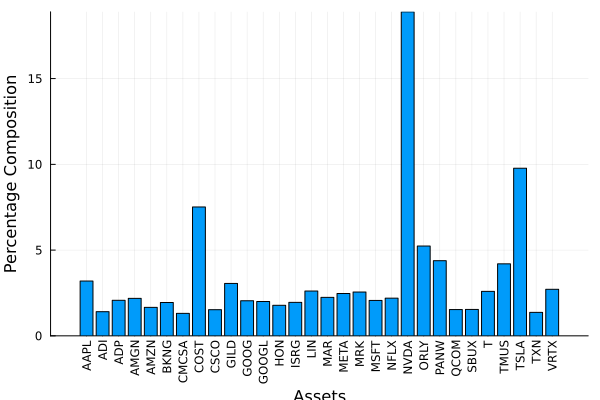

In [4]:
plot_bar(port, :NOC)

### 2.3. Efficient frontier

In [5]:
points = 50
frontier = efficient_frontier!(port, type; points = points)
pretty_table(frontier[:weights]; formatters = fmt2)

┌─────────┬──────────┬─────────┬─────────┬─────────┬─────────┬─────────┬──────────┬─────────┬──────────┬─────────┬─────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬─────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ tickers │        1 │       2 │       3 │       4 │       5 │       6 │        7 │       8 │        9 │      10 │      11 │       12 │       13 │       14 │       15 │       16 │       17 │       18 │       19 │      20 │       21 │       22 │       23 │       24 │       25 │       26 │       27 │       28 │       29 │       30 │       31 │       32 │       33 │       34 │       35 │       36 │       37 │       38 │       39 │     

Plot frontier.

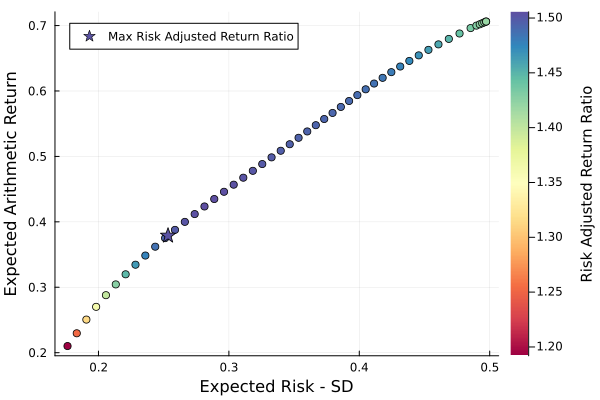

In [6]:
plot_frontier(port, :NOC; rm = rm)

Plot frontier area.

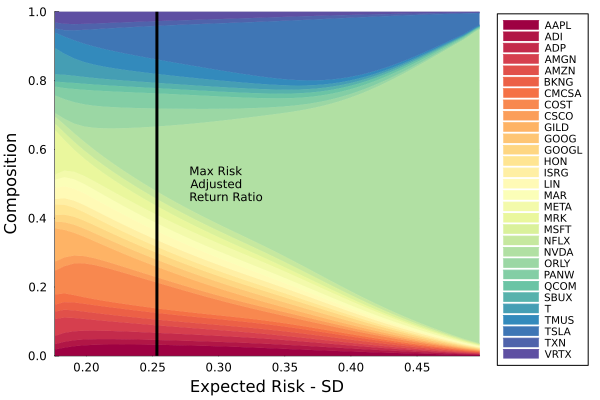

In [7]:
plot_frontier_area(port, :NOC; rm = rm, kwargs_a = (; legendfontsize = 7))

We want to see how the canonical maximum risk-adjusted return ratio portfolio stacks up against other portfolios with greater risk-adjusted return ratios. We can do so using the `frontier` variable.

Frist, we check if the frontier contains the portfolio which maximises the risk-adjusted return ratio (the optimisation can fail in `efficient_frontier!` so we should always check if it succeeded), there is a flag `:sharpe` which is `true` if the optimisation succeeded. The maximum risk-adjusted ratio optimisation is performed last, so its statistics and weights will correspond to the last ones in their respective containers.

We will display them at the start to make it easier to see the behaviour described in [2.1](#2.1.-Optimising-portfolio). We annualise the risk, return, and risk-adjusted return ratio to make comparisons easier.

In [8]:
# Check if the maximum risk-adjusted return ratio optimisation succeeded
if frontier[:sharpe]
    # Optimisations can fail in `efficient_frontier!` so we need to find out how many actually succeeded.
    N = length(frontier[:sharpes])
    # Find all points in the efficient frontier with an actual sharpe ratio higher than the canonical one.
    idx = findall(frontier[:sharpes] .> frontier[:sharpes][end])
    # Add the index of the max risk-adjusted return ratio portfolio at the start.
    idx = [N; idx]
    # Display the anualised returns and risks of the canonical max risk-adjusted return ratio portfolio (the first in the table) as well as all others whose ratios are greater. The first row contains the canonical portfolio.
    pretty_table(DataFrame(:idx => idx, :rets => frontier[:rets][idx] * 252,
                           :risks => frontier[:risks][idx] * sqrt(252),
                           :sharpes => frontier[:sharpes][idx] * sqrt(252));
                 formatters = fmt2)
    # Display their weights. The first column displays the canonical portfolio.
    pretty_table(frontier[:weights][!, [1; (idx .+ 1)]]; formatters = fmt2)
end

┌───────┬──────────┬──────────┬───────────┐
│   idx │     rets │    risks │   sharpes │
│ Int64 │  Float64 │  Float64 │   Float64 │
├───────┼──────────┼──────────┼───────────┤
│    51 │ 37.884 % │ 25.334 % │ 149.539 % │
│    12 │ 38.769 % │ 25.867 % │ 149.879 % │
│    13 │ 39.993 % │ 26.623 % │ 150.221 % │
│    14 │ 41.184 % │ 27.377 % │ 150.433 % │
│    15 │ 42.347 % │  28.13 % │ 150.544 % │
│    16 │ 43.483 % │  28.88 % │ 150.565 % │
│    17 │ 44.592 % │ 29.627 % │ 150.513 % │
│    18 │ 45.678 % │ 30.369 % │  150.41 % │
│    19 │ 46.745 % │ 31.106 % │ 150.276 % │
│    20 │ 47.796 % │ 31.837 % │ 150.126 % │
│    21 │ 48.831 % │  32.56 % │ 149.973 % │
│    22 │ 49.854 % │ 33.273 % │ 149.831 % │
│    23 │ 50.863 % │ 33.976 % │ 149.705 % │
│    24 │  51.86 % │ 34.666 % │ 149.599 % │
└───────┴──────────┴──────────┴───────────┘
┌─────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬─────────┬──────────┬──────────┬──────────┬──────────┐

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*